# Classical methods of machine learning.

In this part of the research we would consider performance of classical pre-neural machine learning methods in terms of sentiment analysis problem. We will use pre-trained word embeddings and simple ways of texts' embeddings generation.

# Preparing data

We will use **IMDb movie review dataset** for binary sentiment analysis (http://ai.stanford.edu/~amaas/data/sentiment/).

Since the data is represented in particular files for each review, we need to apply some helper functions to collect data properly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, WordPunctTokenizer


RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

In [3]:
ROOT = 'drive/My Drive/aclImdb'

def tokenize_text(text):
    return WordPunctTokenizer().tokenize(text)

def collect_data(filename):
    data = []
    with open(os.path.join(ROOT, filename), 'r') as file:
        for paragraph in file.read().splitlines():
            data.append(tokenize_text(paragraph))
    return data

In [4]:
X_train_pos = collect_data('X_train_pos')
X_train_neg = collect_data('X_train_neg')

X_test_pos = collect_data('X_test_pos')
X_test_neg = collect_data('X_test_neg')

In [5]:
X_train = np.array(X_train_pos + X_train_neg)
X_test = np.array(X_test_pos + X_test_neg)

In [6]:
Y_train = np.concatenate((np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))))
Y_test = np.concatenate((np.ones(len(X_test_pos)), np.zeros(len(X_test_neg))))

In [7]:
from sklearn.utils import shuffle

In [8]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=RANDOM_STATE)
X_test, Y_test = shuffle(X_test, Y_test, random_state=RANDOM_STATE)

In [9]:
print(Y_train[:10])

[0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]


# Build word embeddings to represent texts


##Word2Vec embeddings

First we want to load pre-trained **word2vec** to represent words with vectors, so words that appear in similar contexts will have vectors with greater scalar product. Then we can try different ways to represent texts.

In [10]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [ ]:
word2vec = api.load('word2vec-google-news-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Now we can start representing texts to learn an algorithm on the training data that predicts texts' labels! Let's try different ways to get text's embedding.

In [12]:
def mean_text_embedding(text, word_vectors):  
    return np.mean(np.array([word_vectors[word] for word in text if word in word_vectors.keys()]), axis=0)

In [13]:
class EmbeddingMaker():
    def __init__(self, embeddings, text_function):
        self._text_function = text_function
        self.word_vectors = {word : embeddings.get_vector(word) for word in embeddings.vocab.keys()}

    def __call__(self, text):
        return self._text_function(text, self.word_vectors)

In [14]:
def get_corpus_embeddings(embedding_maker, corpus):
    return np.array(list(map(embedding_maker, corpus)))

In [ ]:
word2vec_mean = EmbeddingMaker(word2vec, mean_text_embedding)

In [ ]:
X_train_mean_word2vec = get_corpus_embeddings(word2vec_mean, X_train)

In [ ]:
print(X_train_mean_word2vec.shape)

(25000, 300)


In [ ]:
X_test_mean_word2vec = get_corpus_embeddings(word2vec_mean, X_test)

###Linear models performance

In [18]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [19]:
class EstimatorChecker():
    def __init__(self, estimator, method_name, X_train, Y_train, X_test, Y_test, verbose=0):
        self.estimator = estimator
        self.method_name = method_name
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.verbose = verbose

    def fit_to_best_params(self, param_grid):
        self.searcher = RandomizedSearchCV(self.estimator, param_grid, 
                                           n_iter=5, cv=3, 
                                           random_state=RANDOM_STATE, verbose=self.verbose)
        self.searcher.fit(self.X_train, self.Y_train)

        self.estimator.set_params(**self.searcher.best_params_)
        print('{} best params: {}'.format(self.method_name, self.searcher.best_params_))
        print('Best cross_val score: {}'.format(self.searcher.best_score_))

    def fit(self):
        self.estimator = self.estimator.fit(self.X_train, self.Y_train)

    def predict(self):
        self.Y_pred = self.estimator.predict(self.X_test)
        return self.Y_pred

    def print_scores(self):
        self.scores = [accuracy_score(self.Y_test, self.Y_pred), 
                       precision_score(self.Y_test, self.Y_pred), 
                       recall_score(self.Y_test, self.Y_pred)]

        print('Scores for {}:'.format(self.method_name))
        print('Accuracy: {}'.format(self.scores[0]))
        print('Precision: {}'.format(self.scores[1]))
        print('Recall: {}'.format(self.scores[2]))


    def plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.Y_test, 
                                self.estimator.predict_proba(self.X_test)[:, 1], 
                                pos_label=1)
        plt.figure(figsize=(15, 8))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.grid(c='g')
        plt.title('ROC-curve for {}'.format(self.method_name))
        self.auc = auc(fpr, tpr)
        print('Area under ROC-curve: {:1.4f}'.format(self.auc))
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r')
        plt.show()

    def iterate_and_report(self):
        self.fit()
        self.predict()
        self.print_scores()
        self.plot_roc_curve()

In [ ]:
log_regr = EstimatorChecker(LogisticRegression(max_iter=300, random_state=RANDOM_STATE),
                            method_name='Logistic Regression',
                            X_train=X_train_mean_word2vec,
                            Y_train=Y_train,
                            X_test=X_test_mean_word2vec,
                            Y_test=Y_test)

In [ ]:
log_regr_param_grid = {'fit_intercept' : [True, False], 
                       'C' : np.logspace(-4, 3, num=8)}
log_regr.fit_to_best_params(log_regr_param_grid)

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.8590398667542574


Scores for Logistic Regression:
Accuracy: 0.86136
Precision: 0.8624037227214377
Recall: 0.85992
Area under ROC-curve: 0.9330


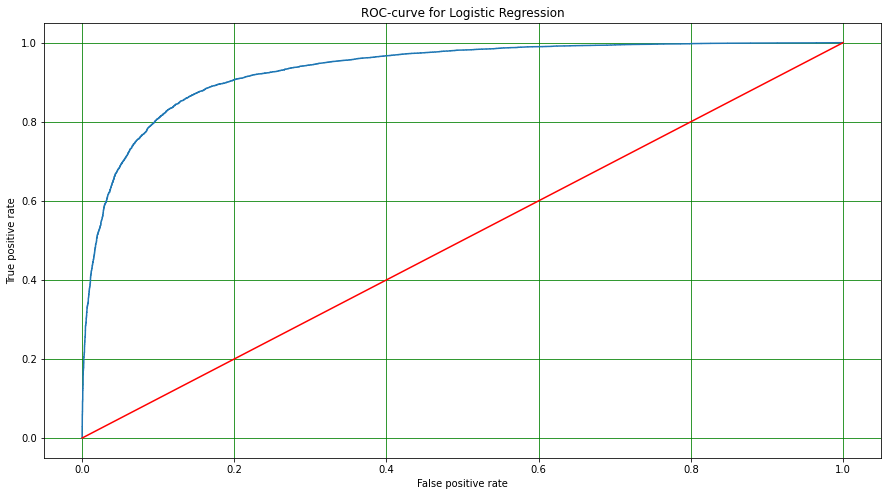

In [ ]:
log_regr.iterate_and_report()

We can now try to use Logistic Regression probability prediction as a measure of positivity of texts or weights of words from the corpus. We will use direct matrix multiplication instead of predict_proba to make it faster.

In [ ]:
word_weights = np.array([np.dot(log_regr.estimator.coef_, word_vector) for word_vector in word2vec_mean.word_vectors.values()])

In [ ]:
greatest_weights = np.argsort(word_weights, axis=0)[-5:].ravel()
print('Words with the greatest lr weights:', [list(word2vec_mean.word_vectors.keys())[i] for i in greatest_weights])

Words with the greatest lr weights: ['offer_unsubstantiated_facts', 'delete_inappropriate_comments', 'Full_versions', 'disallow_commenting', 'Get_exclusive_actionable']


In [ ]:
smallest_weights = np.argsort(word_weights, axis=0)[:5].ravel()
print('Words with the smallest lr weights:', [list(word2vec_mean.word_vectors.keys())[i] for i in smallest_weights])

Words with the smallest lr weights: ['NBA_Game_Summary', 'League_Game_Summary', 'please_login', 'sodium_thiopental', 'shutter_lag']


The problem is that the pre-trained word2vec has some messy words that can have randomly calculated weights, so in our case they get the greatest and the smallest weights. As a sanity check of the idea to directly use coefficients to measure words importance, let's compare such value for some obviously positive and negative words.

In [ ]:
word_examples = ['terrible', 'stupid', 'boring', 'mediocre', 'awesome', 'courageous', 'magnificent', 'fascinating']
for i, word in enumerate(word_examples):
    print(f'Weight of \'{word}\': {float(log_regr.estimator.coef_ @ word2vec_mean.word_vectors[word])}')
    if i + 1 == len(word_examples) // 2:
      print('\n')

Weight of 'terrible': -39.24249016413512
Weight of 'stupid': -77.94140126116311
Weight of 'boring': -83.79329641411975
Weight of 'mediocre': -111.33378666661176


Weight of 'awesome': 50.19814780879713
Weight of 'courageous': 76.93271859363718
Weight of 'magnificent': 48.672802574147276
Weight of 'fascinating': 58.004491511363234


In [ ]:
test_texts_coeffs = log_regr.estimator.predict_proba(X_test_mean_word2vec)[:, 1]
test_texts_indexes = np.argsort(test_texts_coeffs).ravel()

In [ ]:
positive_idx = test_texts_indexes[-1:-4:-1]
print('Most positive texts:\n', '\n'.join('Probability: %.10f' % (proba) + '\ntext: ' + 
                                          ' '.join(text) for text, proba in zip(X_test[positive_idx], 
                                                                                test_texts_coeffs[positive_idx])))

Most positive texts:
 Probability: 0.9999999874
text: a mesmerizing film that certainly keeps your attention ... ben daniels is fascinating ( and courageous ) to watch .
Probability: 0.9999999417
text: just love the interplay between two great characters of stage & screen - veidt & barrymore
Probability: 0.9999999393
text: great story , great music . a heartwarming love story that ' s beautiful to watch and delightful to listen to . too bad there is no soundtrack cd .


In [ ]:
negative_idx = test_texts_indexes[:3]
print('Most negative texts:\n', '\n'.join('Probability: %.10f' % (proba) + '\ntext: ' + 
                                          ' '.join(text) for text, proba in zip(X_test[negative_idx], 
                                                                                test_texts_coeffs[negative_idx])))

Most negative texts:
 Probability: 0.0000000004
text: totally forgettable and almost unwatchable . if you enjoy bad acting , thin plots and predictably weak outcomes , pull up a chair . of passing interest to see bridget fonda look - a - like suzy amis .
Probability: 0.0000000007
text: this was truly horrible . bad acting , bad writing , bad effects , bad scripting , bad camera shots , bad filming , bad characters , bad music , bad editing , bad casting , bad storyline , bad ... well , you get the idea . it was just , just ... what ' s the word ? oh yeah ... bad !
Probability: 0.0000000037
text: what a waste of talent . a very poor , semi - coherent , script cripples this film . rather unimaginative direction , too . some very faint echoes of _fargo_ here , but it just doesn ' t come off .


In [ ]:
Y_pred = log_regr.estimator.predict_proba(X_test_mean_word2vec)[:, 1]

worst_text_idx = np.argsort(- Y_test * np.log(Y_pred) - (1 - Y_test) * np.log(1 - Y_pred))[::-1][:3]

print('Worst classified texts:\n', '\n\n'.join('Predicted: %.10f' % (proba) + '\ntext: ' + 
                                               ' '.join(text) for text, proba in zip(X_test[worst_text_idx], Y_pred[worst_text_idx])))
print(f'Y_true was {Y_test[worst_text_idx]}')

Worst classified texts:
 Predicted: 0.0000281357
text: it ' s not citizen kane , but it does deliver . cleavage , and lots of it . badly acted and directed , poorly scripted . who cares ? i didn ' t watch it for the dialog .

Predicted: 0.9999366506
text: more suspenseful , more subtle , much , much more disturbing ....

Predicted: 0.0000914682
text: basically an endearingly chintzy and moronic $ 1 . 50 version of the nifty early 80 ' s subterranean creature feature favorite " the boogens ," this entertainingly schlocky cheapie centers on a nasty , squirmy , wriggling monster who makes an instant meal out of any unfortunate souls foolhardy enough to go poking around the notoriously off limits gold spike mine . your standard - issue motley assortment of intrepid boneheads -- hectoring hard - nosed mine boss , cute , but insipid blonde babe , feisty lady geologist , boozy , inexplicably aussie - accented (!) seasoned old mine hand , charmless doofus , hunky , jolly guy , and , arguably t

It's interesting that one the worst classified texts seems to be sarcastic.

In [ ]:
rf = EstimatorChecker(RandomForestClassifier(random_state=1),
                      method_name='Random Forest',
                      X_train=X_train_mean_word2vec,
                      Y_train=Y_train,
                      X_test=X_test_mean_word2vec,
                      Y_test=Y_test,
                      verbose=2)

In [ ]:
rf_param_grid = {'n_estimators' : np.linspace(100, 200, 101).astype(int), 
                 'max_depth' : np.linspace(5, 20, 6).astype(int)}
rf.fit_to_best_params(rf_param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=137, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=137, max_depth=5, total=  17.3s
[CV] n_estimators=137, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV] .................... n_estimators=137, max_depth=5, total=  17.2s
[CV] n_estimators=137, max_depth=5 ...................................
[CV] .................... n_estimators=137, max_depth=5, total=  17.2s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  30.0s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  32.1s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  30.1s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .................... n_estimators=172, max_depth=5, total=  21.5s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .................... n_estimators=172, max_depth=5, total=  21.6s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.9min finished


Random Forest best params: {'n_estimators': 133, 'max_depth': 11}
Best cross_val score: 0.8125599466023278


Scores for Random Forest:
Accuracy: 0.80516
Precision: 0.8104500691788069
Recall: 0.79664
Area under ROC-curve: 0.8883


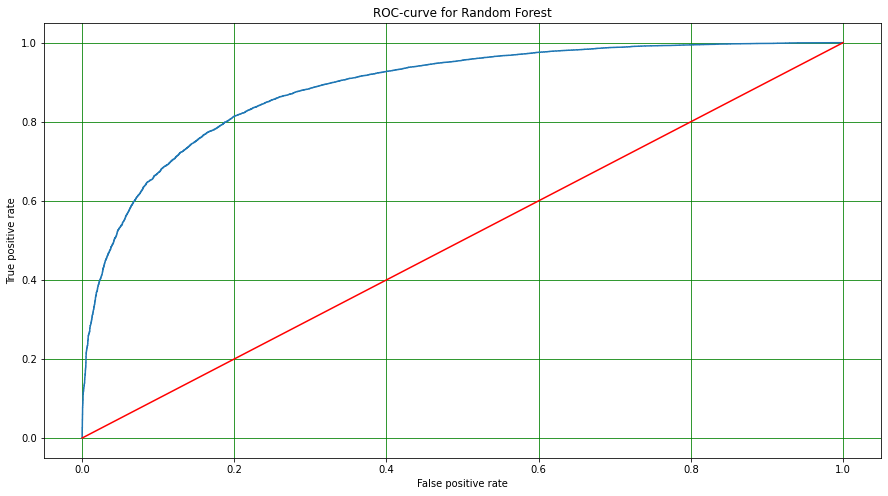

In [ ]:
rf.iterate_and_report()

In [ ]:
sgd = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                       method_name='SGD',
                       X_train=X_train_mean_word2vec,
                       Y_train=Y_train,
                       X_test=X_test_mean_word2vec,
                       Y_test=Y_test)

In [ ]:
sgd_param_grid = {'loss' : ['modified_huber', 'log'],
                  'penalty' : ['l1', 'l2', 'elasticnet']}
sgd.fit_to_best_params(sgd_param_grid)

SGD best params: {'penalty': 'l1', 'loss': 'modified_huber'}
Best cross_val score: 0.8531598523360181


Scores for SGD:
Accuracy: 0.85576
Precision: 0.8626651443483934
Recall: 0.84624
Area under ROC-curve: 0.9279


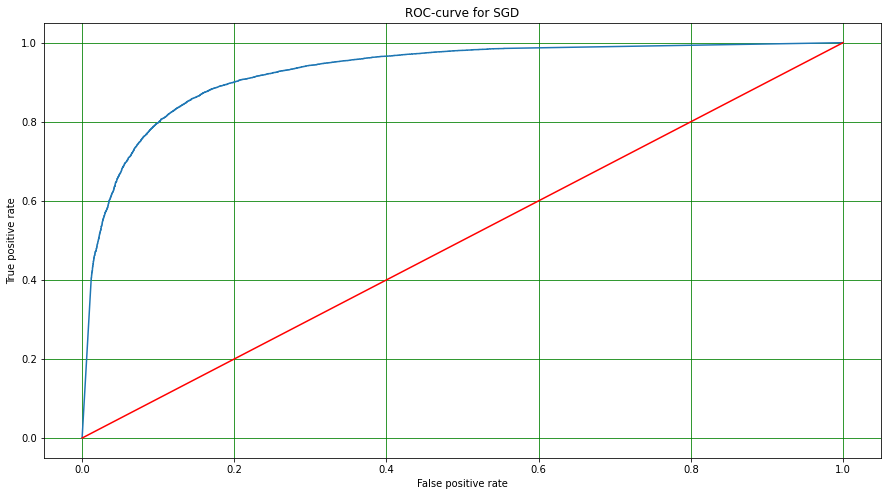

In [ ]:
sgd.iterate_and_report()

Because of the way we form word and text embeddings, we can't just scale the data after that, because the idea of word2vec would be lost. So SVM has problems with convergency, but we can check it's quality after a fixed amount of iterations.

In [ ]:
svm = EstimatorChecker(SVC(max_iter=1000, random_state=RANDOM_STATE, probability=True),
                       method_name='SVM',
                       X_train=X_train_mean_word2vec,
                       Y_train=Y_train,
                       X_test=X_test_mean_word2vec,
                       Y_test=Y_test,
                       verbose=2)

In [ ]:
svm_param_grid = {'C' : np.logspace(-4, 3, 8),
                  'kernel' : ['linear', 'poly', 'rbf']}
svm.fit_to_best_params(svm_param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] kernel=poly, C=1.0 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ............................... kernel=poly, C=1.0, total= 2.1min
[CV] kernel=poly, C=1.0 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ............................... kernel=poly, C=1.0, total= 2.1min
[CV] kernel=poly, C=1.0 ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ............................... kernel=poly, C=1.0, total= 2.1min
[CV] kernel=linear, C=100.0 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=100.0, total= 1.3min
[CV] kernel=linear, C=100.0 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=100.0, total= 1.3min
[CV] kernel=linear, C=100.0 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=100.0, total= 1.3min
[CV] kernel=linear, C=0.001 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=0.001, total= 2.1min
[CV] kernel=linear, C=0.001 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=0.001, total= 2.1min
[CV] kernel=linear, C=0.001 ..........................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ........................... kernel=linear, C=0.001, total= 2.1min
[CV] kernel=rbf, C=1.0 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................................ kernel=rbf, C=1.0, total= 2.3min
[CV] kernel=rbf, C=1.0 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................................ kernel=rbf, C=1.0, total= 2.3min
[CV] kernel=rbf, C=1.0 ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................................ kernel=rbf, C=1.0, total= 2.3min
[CV] kernel=rbf, C=100.0 .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .............................. kernel=rbf, C=100.0, total= 2.1min
[CV] kernel=rbf, C=100.0 .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .............................. kernel=rbf, C=100.0, total= 2.0min
[CV] kernel=rbf, C=100.0 .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .............................. kernel=rbf, C=100.0, total= 2.0min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 29.5min finished


SVM best params: {'kernel': 'linear', 'C': 100.0}
Best cross_val score: 0.6461212948157956


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Scores for SVM:
Accuracy: 0.5384
Precision: 0.52356637863315
Recall: 0.85312
Area under ROC-curve: 0.6028


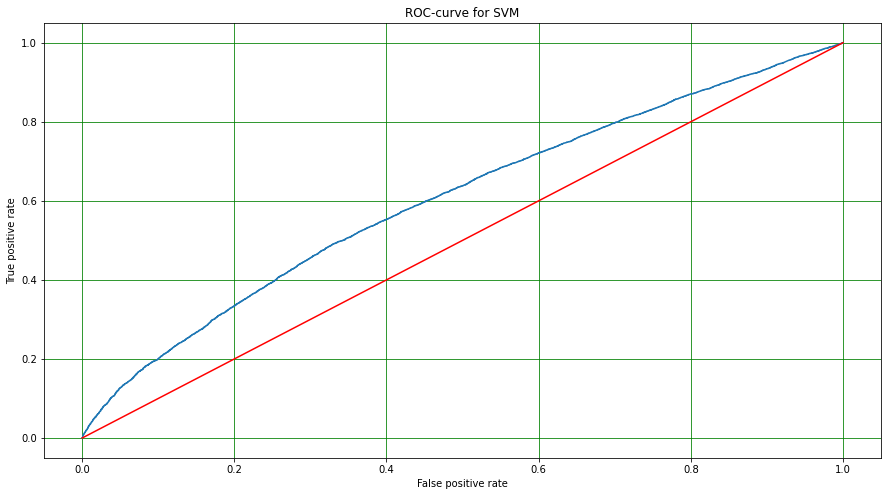

In [ ]:
svm.iterate_and_report()

Yes, SVM has problems with convergence, but now we can try to train it more with best obtained params and see what we can get.

In [ ]:
best_params_svm = EstimatorChecker(SVC(max_iter=5000, kernel='linear', C=0.001, random_state=RANDOM_STATE, probability=True),
                                   method_name='Best params SVM',
                                   X_train=X_train_mean_word2vec,
                                   Y_train=Y_train,
                                   X_test=X_test_mean_word2vec,
                                   Y_test=Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Scores for Best params SVM:
Accuracy: 0.541
Precision: 0.5214175268502653
Recall: 0.99816
Area under ROC-curve: 0.9022


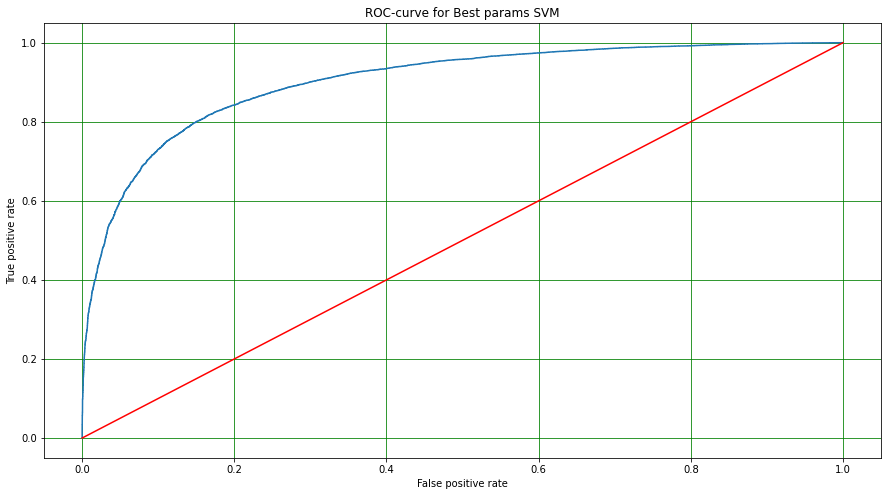

In [ ]:
best_params_svm.iterate_and_report()

In [25]:
from IPython.display import display


def print_results_table(models):
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Roc-auc']

    results_table = pd.DataFrame(list(map(lambda x: [x.method_name] + x.scores + [x.auc], models)), columns=columns)
    display(results_table)

In [ ]:
print_results_table([log_regr, rf, svm, best_params_svm, sgd])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.86136,0.862404,0.85992,0.932993
1,Random Forest,0.80516,0.810450,0.79664,0.888324
2,SVM,0.53840,0.523566,0.85312,0.602824
3,Best params SVM,0.54100,0.521418,0.99816,0.902230
4,SGD,0.85576,0.862665,0.84624,0.927884


Interesting results! LR and SGD have the greatest roc-auc score. SGD also has the best precision, but smaller recall. As we also can see, well-trained SVM gets huge recall and even not bad roc-auc score, but a very bad accuracy and precision. 

In later analysis we will use Logistic Regression and SGD, because they train much faster, have the best roc-auc scores and not bad other scores.

Let's now try another way to form text embeddings, for instance, as a sum of all words embeddings instead of taking mean. On the one hand, it causes the dependance between embeddings and text lengths, but on the other hand necessary words may not 'drown' in hundreds of unnecessary tokens.

In [ ]:
def sum_text_embedding(text, word_vectors):  
    return np.sum(np.array([word_vectors[word] for word in text if word in word_vectors.keys()]), axis=0)

In [ ]:
word2vec_sum = EmbeddingMaker(word2vec, sum_text_embedding)

In [ ]:
X_train_sum_word2vec = get_corpus_embeddings(word2vec_sum, X_train)

X_test_sum_word2vec = get_corpus_embeddings(word2vec_sum, X_test)

In [ ]:
log_regr_sum = EstimatorChecker(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_sum_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_sum_word2vec,
                                Y_test=Y_test)

Logistic Regression best params: {'fit_intercept': True, 'C': 0.001}
Best cross_val score: 0.8587199307506737
Scores for Logistic Regression:
Accuracy: 0.85948
Precision: 0.858647936786655
Recall: 0.86064
Area under ROC-curve: 0.9273


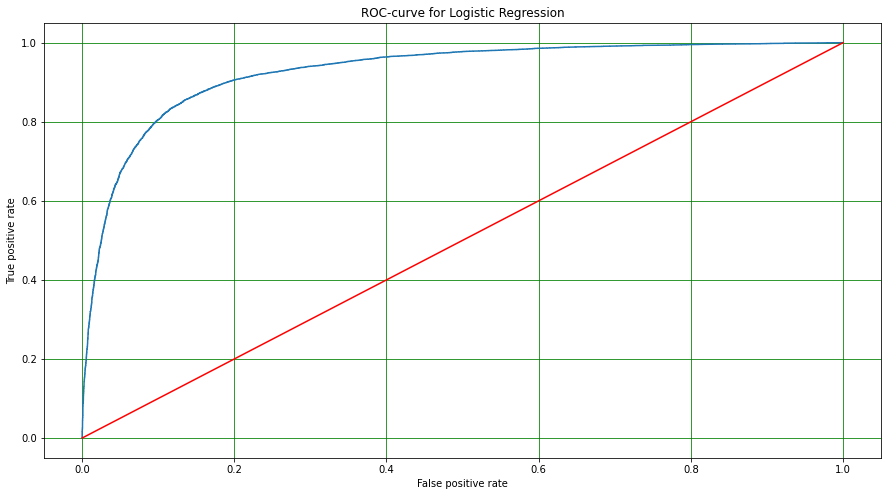

In [ ]:
log_regr_sum.fit_to_best_params(log_regr_param_grid)
log_regr_sum.iterate_and_report()

In [ ]:
sgd_sum = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                           method_name='SGD',
                           X_train=X_train_sum_word2vec,
                           Y_train=Y_train,
                           X_test=X_test_sum_word2vec,
                           Y_test=Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_mo

SGD best params: {'penalty': 'l1', 'loss': 'log'}
Best cross_val score: 0.8366405690544876
Scores for SGD:
Accuracy: 0.8524
Precision: 0.8476716653512234
Recall: 0.8592
Area under ROC-curve: 0.9215


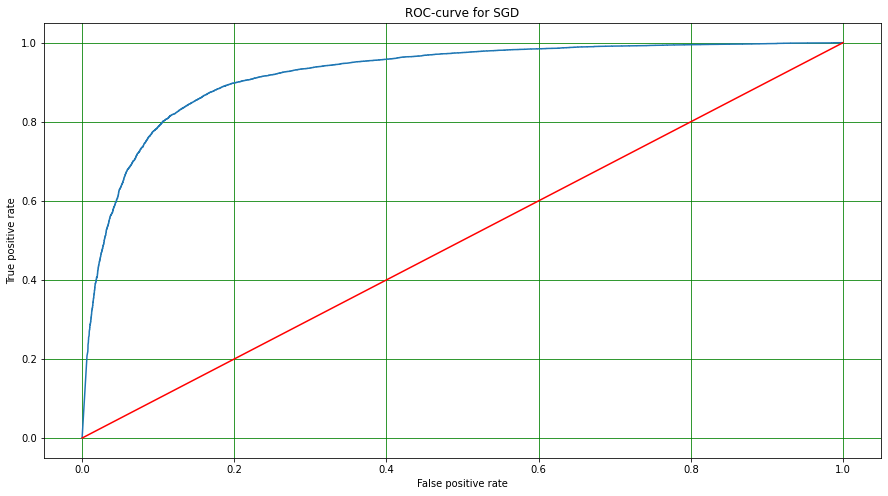

In [ ]:
sgd_sum.fit_to_best_params(sgd_param_grid)
sgd_sum.iterate_and_report()

In [ ]:
print_results_table([log_regr_sum, sgd_sum])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.85948,0.858648,0.86064,0.927280
1,SGD,0.85240,0.847672,0.85920,0.921534


It looks like Logistic Regression's performance hasn't changed, SGD performs a bit worse. So, this approach seems to be not better than taking mean of words' embeddings.

Let's now try taking median on every component of words' embeddings.

In [ ]:
def median_text_embedding(text, word_vectors):
    return np.median(np.array([word_vectors[word] for word in text if word in word_vectors.keys()]), axis=0)

In [ ]:
word2vec_median = EmbeddingMaker(word2vec, median_text_embedding)

In [ ]:
X_train_median_word2vec = get_corpus_embeddings(word2vec_median, X_train)

X_test_median_word2vec = get_corpus_embeddings(word2vec_median, X_test)

In [ ]:
log_regr_median = EstimatorChecker(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                   method_name='Logistic Regression',
                                   X_train=X_train_median_word2vec,
                                   Y_train=Y_train,
                                   X_test=X_test_median_word2vec,
                                   Y_test=Y_test)

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.8382799050862922
Scores for Logistic Regression:
Accuracy: 0.83884
Precision: 0.8414899621059421
Recall: 0.83496
Area under ROC-curve: 0.9154


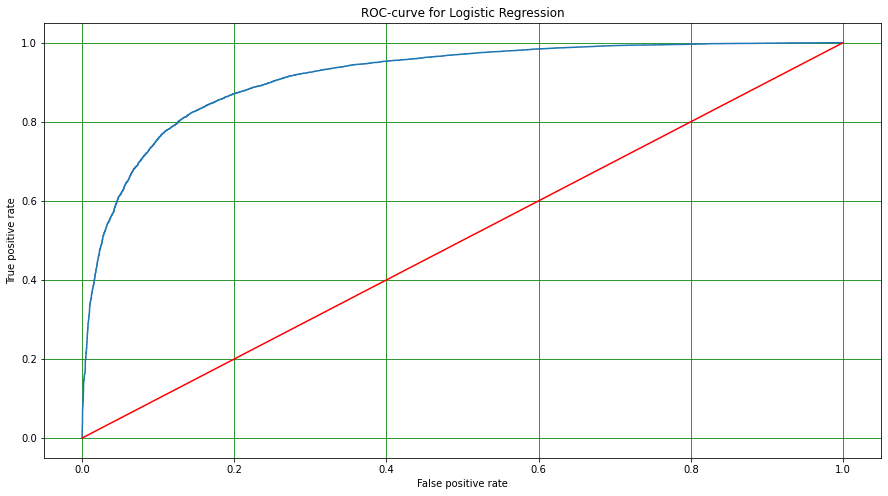

In [ ]:
log_regr_median.fit_to_best_params(log_regr_param_grid)
log_regr_median.iterate_and_report()

In [ ]:
sgd_median = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                              method_name='SGD',
                              X_train=X_train_median_word2vec,
                              Y_train=Y_train,
                              X_test=X_test_median_word2vec,
                              Y_test=Y_test)

SGD best params: {'penalty': 'l1', 'loss': 'modified_huber'}
Best cross_val score: 0.8347198682763725
Scores for SGD:
Accuracy: 0.83436
Precision: 0.8541048885876472
Recall: 0.80648
Area under ROC-curve: 0.9108


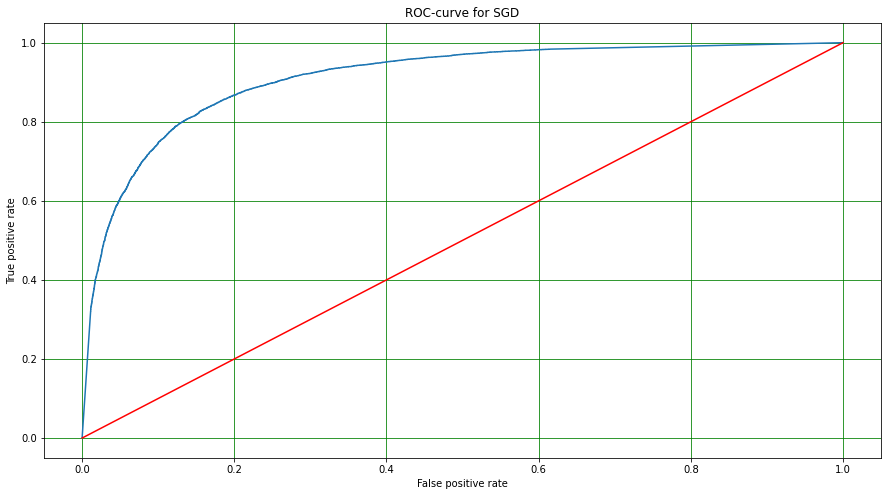

In [ ]:
sgd_median.fit_to_best_params(sgd_param_grid)
sgd_median.iterate_and_report()

In [ ]:
print_results_table([log_regr_median, sgd_median])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.83884,0.841490,0.83496,0.915403
1,SGD,0.83436,0.854105,0.80648,0.910798


Logistic Regression and SGD are still pretty stable :) Although roc-auc scores have decreased.


So let's try the last approch: we'll take maximum of each component and see what happens.

In [ ]:
def max_text_embedding(text, word_vectors):
    return np.max(np.array([word_vectors[word] for word in text if word in word_vectors.keys()]), axis=0)

In [ ]:
word2vec_max = EmbeddingMaker(word2vec, max_text_embedding)

In [ ]:
X_train_max_word2vec = get_corpus_embeddings(word2vec_max, X_train)

X_test_max_word2vec = get_corpus_embeddings(word2vec_max, X_test)

In [ ]:
print(X_train_max_word2vec.shape)

(25000, 300)


In [ ]:
log_regr_max = EstimatorChecker(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_max_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_max_word2vec,
                                Y_test=Y_test)

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.7468798727951037
Scores for Logistic Regression:
Accuracy: 0.7444
Precision: 0.7438148443735035
Recall: 0.7456
Area under ROC-curve: 0.8248


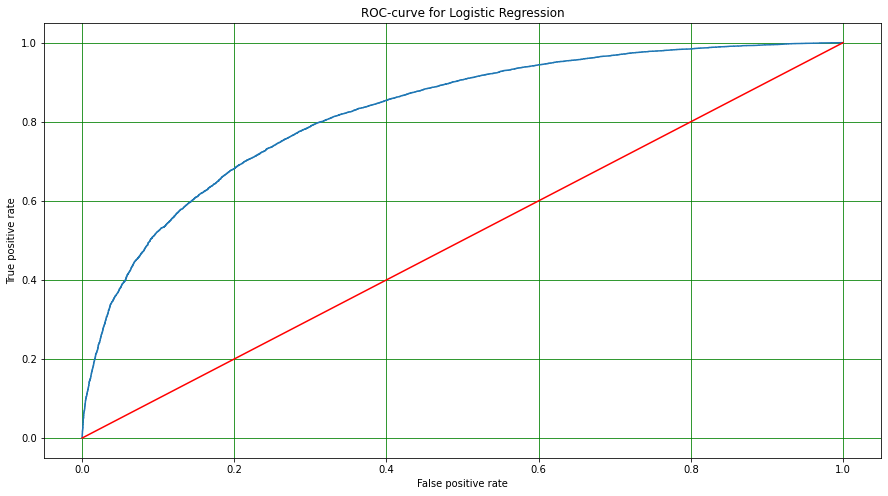

In [ ]:
log_regr_max.fit_to_best_params(log_regr_param_grid)
log_regr_max.iterate_and_report()

In [ ]:
sgd_max = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_max_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_max_word2vec,
                          Y_test=Y_test
                       )

SGD best params: {'penalty': 'l1', 'loss': 'log'}
Best cross_val score: 0.7172788375417906
Scores for SGD:
Accuracy: 0.74292
Precision: 0.7356616220411331
Recall: 0.75832
Area under ROC-curve: 0.8239


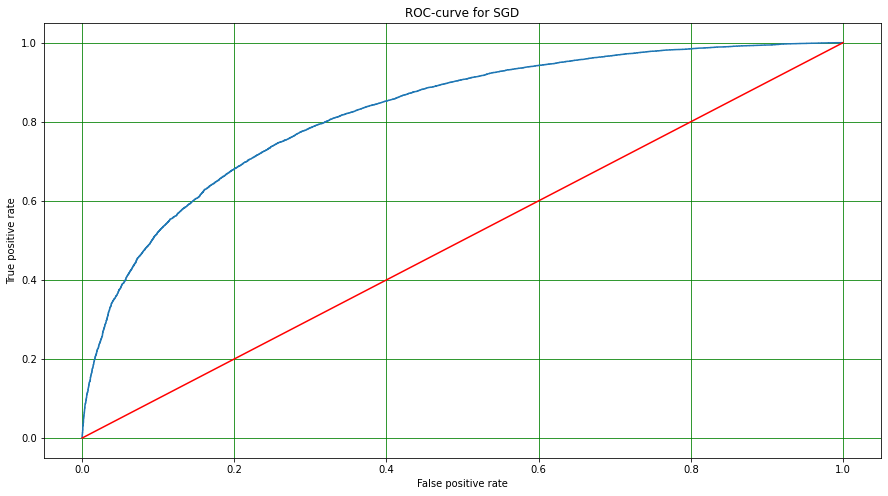

In [ ]:
sgd_max.fit_to_best_params(sgd_param_grid)
sgd_max.iterate_and_report()

In [ ]:
print_results_table([log_regr_max, sgd_max])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.74440,0.743815,0.74560,0.824778
1,SGD,0.74292,0.735662,0.75832,0.823907


So, we can see that the last approach was the worst one - all scores are now much smaller.

---

As a conclusion we have that Logistic Regression got the most sustained results and kept one the highest roc-auc scores at all kinds of texts' embeddings. But the best approach was to take the mean embeddings.

##Glove embeddings

Word2vec isn't the only way to get words embeddings. Another popular type of embeddings is Glove. Now we can also try them to get words embedding with the best models from the last paragraph: Logistic Regression and SGD, and the best way of getting text's embeddings: taking mean of embeddings of it's words.

In [11]:
glove = api.load('glove-wiki-gigaword-300')

[=================================================-] 98.5% 370.5/376.1MB downloaded

In [15]:
glove_mean = EmbeddingMaker(glove, mean_text_embedding)

In [16]:
X_train_mean_glove = get_corpus_embeddings(glove_mean, X_train)

X_test_mean_glove = get_corpus_embeddings(glove_mean, X_test)

###Linear models performance

In [20]:
log_regr_glove = EstimatorChecker(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                  method_name='Logistic Regression',
                                  X_train=X_train_mean_glove,
                                  Y_train=Y_train,
                                  X_test=X_test_mean_glove,
                                  Y_test=Y_test)

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.8403599450913481
Scores for Logistic Regression:
Accuracy: 0.83636
Precision: 0.8400323493732309
Recall: 0.83096
Area under ROC-curve: 0.9162


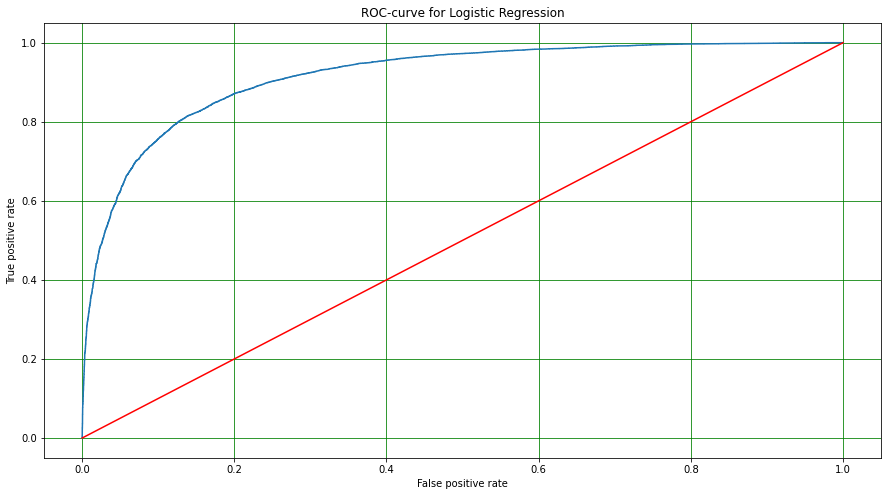

In [22]:
log_regr_param_grid = {'fit_intercept' : [True, False], 
                       'C' : np.logspace(-4, 3, num=8)}
log_regr_glove.fit_to_best_params(log_regr_param_grid)
log_regr_glove.iterate_and_report()

In [23]:
sgd_glove = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                             method_name='SGD',
                             X_train=X_train_mean_glove,
                             Y_train=Y_train,
                             X_test=X_test_mean_glove,
                             Y_test=Y_test)

SGD best params: {'penalty': 'elasticnet', 'loss': 'modified_huber'}
Best cross_val score: 0.8327197450749001
Scores for SGD:
Accuracy: 0.8352
Precision: 0.8572646657571623
Recall: 0.80432
Area under ROC-curve: 0.9141


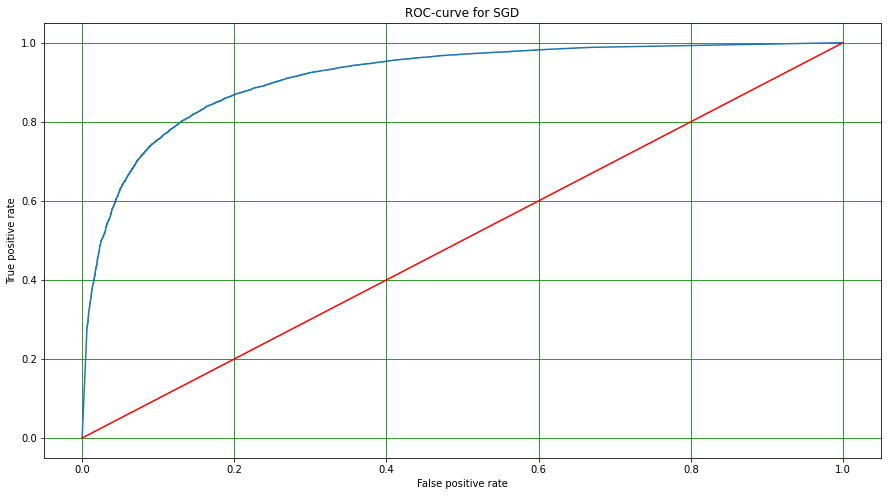

In [24]:
sgd_param_grid = {'loss' : ['modified_huber', 'log'],
                  'penalty' : ['l1', 'l2', 'elasticnet']}
sgd_glove.fit_to_best_params(sgd_param_grid)
sgd_glove.iterate_and_report()

In [26]:
print_results_table([log_regr_glove, sgd_glove])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.83636,0.840032,0.83096,0.916242
1,SGD,0.83520,0.857265,0.80432,0.914128


So, as a conclusion, both models have worse performance with glove embeddings. Maybe the reason for that is the fact that pre-trained word2vec had much bigger training corpus than glove.

---

Probably the best model for this part of research is Logistic Regression with C=100, without bias vector, with text embeddings taken as mean of word2vec embeddings.